In [1]:
# %load_ext autoreload

# import time

# import struct
# import array
# import gc

import numpy as np
# %matplotlib notebook  # interactive plots
import matplotlib.pylab as plt

from mim_data_utils import DataLogger, DataReader

np.set_printoptions(suppress=True, precision=2, sign=' ')
from scipy.spatial.transform import Rotation

import pinocchio as pin
from robot_properties_solo.solo12wrapper import Solo12Config

In [30]:
plt.rcParams['figure.dpi'] = 100  # default 72.0

# Init Data

In [3]:
pin_robot = Solo12Config.buildRobotWrapper()
reader = DataReader('2021-07-20_11-10-52_reactive.mds')

idx: 0 fields: 21
[('x_des', 12), ('xd_des', 12), ('w_com', 6), ('kc', 3), ('dc', 3), ('kb', 3), ('db', 3), ('joint_positions', 12), ('joint_velocities', 12), ('slider_positions', 4), ('imu_gyroscope', 3), ('zero_sliders', 4), ('control_time', 1), ('q', 19), ('dq', 18), ('com', 3), ('rel_eff', 12), ('vicon_leg_hl', 13), ('F', 12), ('dx_des', 12), ('tau', 18)]


In [4]:
reader_q = reader.data['q']
reader_dq = reader.data['dq']
reader_tau = reader.data['tau']
reader_vicon_leg = reader.data['vicon_leg_hl']
reader_imu = reader.data['imu_gyroscope']

calculated_f = np.empty((reader_q.shape[0], 4, 3))
calculated_omi = np.empty((reader_q.shape[0], 3))

In [5]:
# calculate f
for ms in range(reader_q.shape[0]):
    q = reader_q[ms]
    dq = reader_dq[ms]
    pin_robot.computeJointJacobians(q)

    for i, endeff_name in enumerate(['FL_ANKLE', 'FR_ANKLE', 'HL_ANKLE', 'HR_ANKLE']):             
        frame_id = pin_robot.model.getFrameId(endeff_name)
        pin_robot.framePlacement(q, index=frame_id)
        J = pin_robot.getFrameJacobian(frame_id=frame_id, rf_frame=pin.ReferenceFrame.LOCAL_WORLD_ALIGNED)
        J_inv = np.linalg.pinv(J[:3, 6+3*i:9+3*i].T) * -1
        h = pin_robot.nle(q, dq)
        F = np.hstack((np.zeros(6), reader_tau[ms][6:]))
        calculated_f[ms, i] = J_inv @ ((F - h)[6+3*i:9+3*i])

# plt.plot(calculated_f[:, :, 2])

In [6]:
# calculate f without h (nle)
without_h = np.empty((reader_q.shape[0], 4, 3))
for ms in range(reader_q.shape[0]):
    q = reader_q[ms]
    dq = reader_dq[ms]
    pin_robot.computeJointJacobians(q)

    for i, endeff_name in enumerate(['FL_ANKLE', 'FR_ANKLE', 'HL_ANKLE', 'HR_ANKLE']):             
        frame_id = pin_robot.model.getFrameId(endeff_name)
        pin_robot.framePlacement(q, index=frame_id)
        J = pin_robot.getFrameJacobian(frame_id=frame_id, rf_frame=pin.ReferenceFrame.LOCAL_WORLD_ALIGNED)
        J_inv = np.linalg.pinv(J[:3, 6+3*i:9+3*i].T) * -1
#         h = pin_robot.nle(q, dq)
        h = np.zeros(18)
        F = np.hstack((np.zeros(6), reader_tau[ms][6:]))
        without_h[ms, i] = J_inv @ ((F - h)[6+3*i:9+3*i])

# (Mostly) Plotting Data

In [7]:
_s0 = slice(1000, 2000)
# plt.plot(np.sum(calculated_f[_s0, :, 2], axis=1), label='a')
# plt.plot(without_h[_s0, 2, 2])

In [8]:
# f (with h) - f (without h)
# plt.plot(calculated_f[:, 2, 2])
# plt.plot( without_h[:, 2, 2])

In [9]:
# calculate and plot values of h (nle)
just_hs = np.empty((reader_q.shape[0], 4, 18))
for ms in range(reader_q.shape[0]):
    q = reader_q[ms]
    dq = reader_dq[ms]
    pin_robot.computeJointJacobians(q)

    for i, endeff_name in enumerate(['FL_ANKLE', 'FR_ANKLE', 'HL_ANKLE', 'HR_ANKLE']):       
        just_hs[ms, i] = pin_robot.nle(q, dq)

#         frame_id = pin_robot.model.getFrameId(endeff_name)
#         pin_robot.framePlacement(q, index=frame_id)
#         J = pin_robot.getFrameJacobian(frame_id=frame_id, rf_frame=pin.ReferenceFrame.LOCAL_WORLD_ALIGNED)
#         J_inv = np.linalg.pinv(J[:3, 6+3*i:9+3*i].T) * -1
# #         h = pin_robot.nle(q, dq)
#         # h = np.zeros(18)
#         F = np.hstack((np.zeros(6), reader_tau[ms][6:]))
#         without_h[ms, i] = J_inv @ ((F - h)[6+3*i:9+3*i])

# for i in range(18):
#     print(i)
#     plt.plot(just_hs[:, 2, i], label=str(i))
#     plt.legend()
#     plt.show()

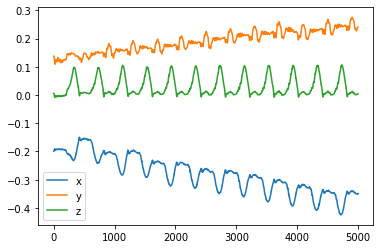

In [10]:
# plot xyz of forward kinematics
forwardK = np.empty((reader_q.shape[0], 3))
# for i_omi in range(1, 14):
for ms in range(reader_q.shape[0]):
    q = reader_q[ms]
#     dq = all_dq[ms]
    pin_robot.computeJointJacobians(q)
#     pin_robot.forwardKinematics(q)
    pin_robot.framesForwardKinematics(q)
    forwardK[ms] = pin_robot.data.oMf[pin_robot.model.getFrameId('HL_ANKLE')].translation

plt.plot(forwardK)
plt.legend('xyz')
plt.show()

Text(0.5, 1.0, 'all ground reaction force')

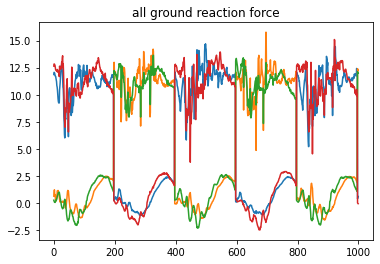

In [11]:
# plot GRF
plt.plot(calculated_f[1000:2000, :, 2])
plt.title('all ground reaction force')

Text(0.5, 1.0, "all legs' forces")

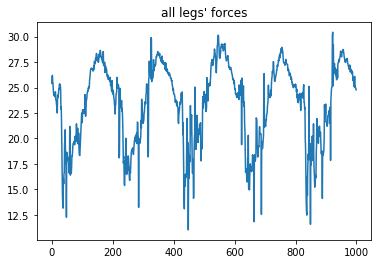

In [12]:
# plot the sum of all leg forces
plt.plot(np.sum(calculated_f[1000:2000, :, 2], axis=1))
plt.title("all legs' forces")

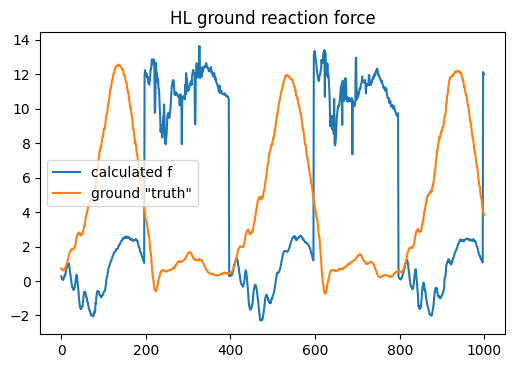

In [32]:
# compare calculated f and z values of forward kinematics
plt.plot(calculated_f[1000:2000, 2, 2])
plt.plot(forwardK[1000:2000, 2] * 120)
# plt.plot(all_imu[1000:2000, 0] * 8)
plt.title('HL ground reaction force')
plt.legend(('calculated f','ground "truth"'))
# plt.legend()

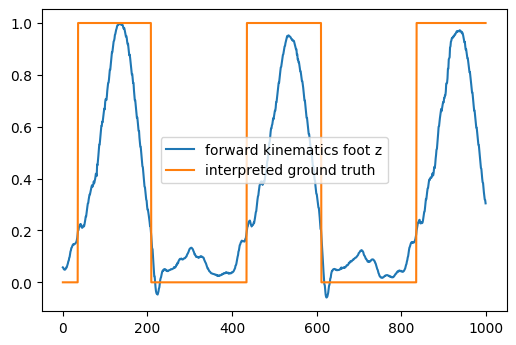

In [33]:
plt.plot(forwardK[1000:2000, 2] * 1/np.max(forwardK[1000:2000:, 2]), label='forward kinematics foot z')
plt.plot(np.where(forwardK[1000:2000, 2] > 0.02, 1, 0), label='interpreted ground truth')
plt.plot()
plt.legend()

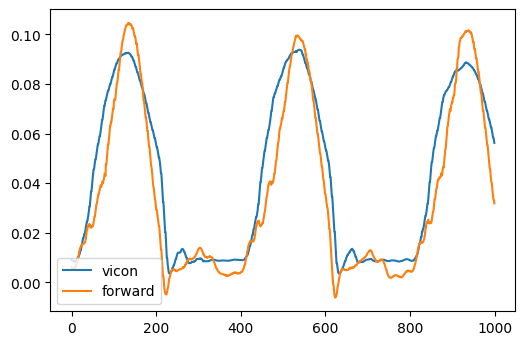

In [57]:
slice_compare_viconforwardK = slice(1000,2000)
plt.plot(reader_vicon_leg[slice_compare_viconforwardK, 2], label='vicon')
plt.plot(forwardK[slice_compare_viconforwardK, 2], label='forward')
plt.legend()

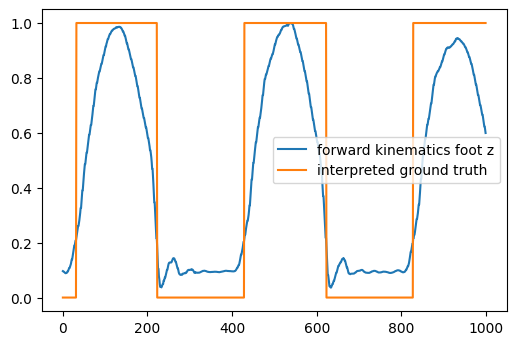

In [58]:
plt.plot(reader_vicon_leg[1000:2000, 2] * 1/np.max(reader_vicon_leg[1000:2000:, 2]), label='forward kinematics foot z')
plt.plot(np.where(reader_vicon_leg[1000:2000, 2] > 0.02, 1, 0), label='interpreted ground truth')
plt.plot()
plt.legend()

Text(0.5, 1.0, 'body')

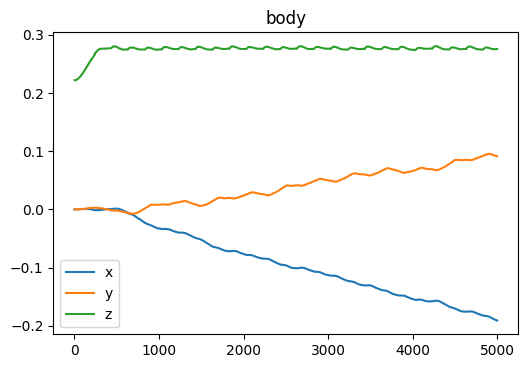

In [39]:
plt.plot(reader_q[:, :3])
plt.legend('xyz')
plt.title('body')

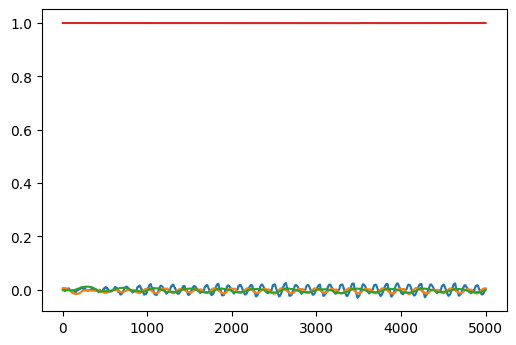

In [40]:
plt.plot(reader_q[:, 3:7])

In [45]:
reader.data.keys()

dict_keys(['x_des', 'xd_des', 'w_com', 'kc', 'dc', 'kb', 'db', 'joint_positions', 'joint_velocities', 'slider_positions', 'imu_gyroscope', 'zero_sliders', 'control_time', 'q', 'dq', 'com', 'rel_eff', 'vicon_leg_hl', 'F', 'dx_des', 'tau'])

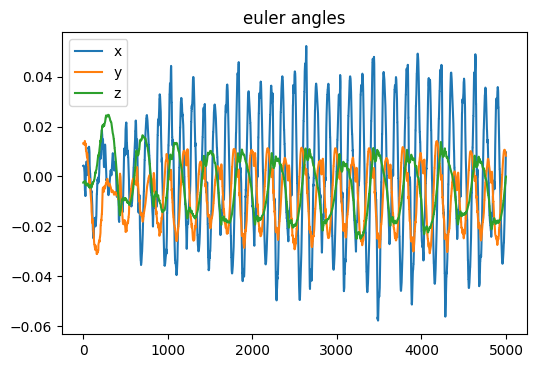

In [48]:
calculated_euler_angles = Rotation.from_quat(reader_q[:, 3:7]).as_euler('xyz')
plt.plot(calculated_euler_angles)
plt.title('euler angles')
plt.legend('xyz')

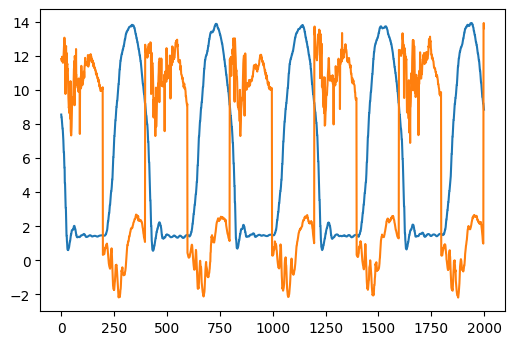

In [51]:
slice_viconcalculatedF = slice(2000, 4000)
plt.plot(reader_vicon_leg[slice_viconcalculatedF, 2] * 1/np.max(reader_vicon_leg[slice_viconcalculatedF, 2]) * np.max(calculated_f[slice_viconcalculatedF, 2, 2]))
plt.plot(calculated_f[slice_viconcalculatedF, 2, 2])

In [21]:
np.sum([i.mass for i in pin_robot.model.inertias]) * 9.81
#24.5

24.525027369900005

# Logistic Regression

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
# input is GRF: x, want to estimate "ground truth": y
x = calculated_f
y = np.where(reader_vicon_leg[:, 2] > 0.02, 1, 0)  # vicon less noisy than forwward kinematics data



logreg = LogisticRegression()